In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from numpy.random import normal, uniform

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

from AFML_module import CLA

import seaborn as sns

import yfinance as yf

In [7]:
### simulation. use 16.3.A
# generate data produces a matrix of time series where some number are correlated and some are uncorrelated. 


def generate_data(num_obs, size0, size1, sigma1):
    np.random.seed(seed=12345)
    random.seed(12345)

    x = np.random.normal(0, 1, size=(num_obs, size0))

    cols = [random.randint(0,size0-1) for i in range(size1)]
    y = x[:, cols] + np.random.normal(0, sigma1, size=(num_obs, len(cols)))
    x = np.append(x, y, axis=1)
    x = pd.DataFrame(x, columns=range(1, x.shape[1]+1))
    return x, cols

    
def plot_heatmap(corr):
    plt.figure(figsize=(12, 8)) # Adjust figure size as needed
    heatmap = sns.heatmap(corr, annot=False, cmap='coolwarm')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0)
    heatmap.set_yticklabels(heatmap.get_xticklabels(), rotation=0)
    return heatmap

def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio, which is the best portfolio for a diagonal covariance matrix
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp

def correlation_distance(corr):
    # distance metric between two time series based on their correlations
    dist = np.sqrt(0.5*(1 - corr))
    return dist

def get_cluster_variance(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar


def recursive_bisection(cov, sortIx):
    w = pd.Series(1.0,index=sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems = [i[j:k] for i in cItems for j,k in ((0,len(i)//2), (len(i)//2,len(i))) if len(i)>1] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i+1] # cluster 2
            cVar0 = get_cluster_variance(cov, cItems0)
            cVar1 = get_cluster_variance(cov, cItems1)
            alpha = 1-cVar0/(cVar0+cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w
    

# Exercises

### 16.1

Given the PnL series on N investment strategies:

(a) Align them to the average frequency of their bets (e.g., weekly observations
for strategies that trade on a weekly basis). Hint: This kind of data alignment
is sometimes called “downsampling.”

(b) Compute the covariance of their returns, V.

(c) Identify the hierarchical clusters among the N strategies.

(d) Plot the clustered correlation matrix of the N strategies

In [5]:
# we'll take a very simple strategy: every Monday, buy a share of the following 10 ETFs and sell on Friday, both
# at the close for simplicity. For fun, we'll include a few that are virtually identical, e.g. VOO and SPY 

# XLF --> Finance
# XLE --> Energy
# BTC-USD --> Bitcoin
# VEA --> Vanguard FTSE Developed Markets ETF 
# XLB --> Materials
# SOXX --> Semiconductors
# IBB --> Biotech
# SPY
# QQQ
# USO --> Oil
# UNG --> Gas

tickers = ["XLF", "XLE", "BTC-USD", "VEA", "SOXX", "IBB", "SPY", "QQQ", "USO", "UNG"]

data = yf.download(tickers, start='2022-01-01', end='2023-01-01')

close = data["Close"].copy()
returns = close.shift(-4) / close - 1
returns = returns.loc[close.index.day_name()=="Monday"]

/var/folders/by/7cbzhksj7t3d6f129n8csbb00000gn/T/ipykernel_81684/823211644.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2022-01-01', end='2023-01-01')
[*********************100%***********************]  10 of 10 completed


Text(0.5, 1.0, 'Correlation of ETF Weekly Returns')

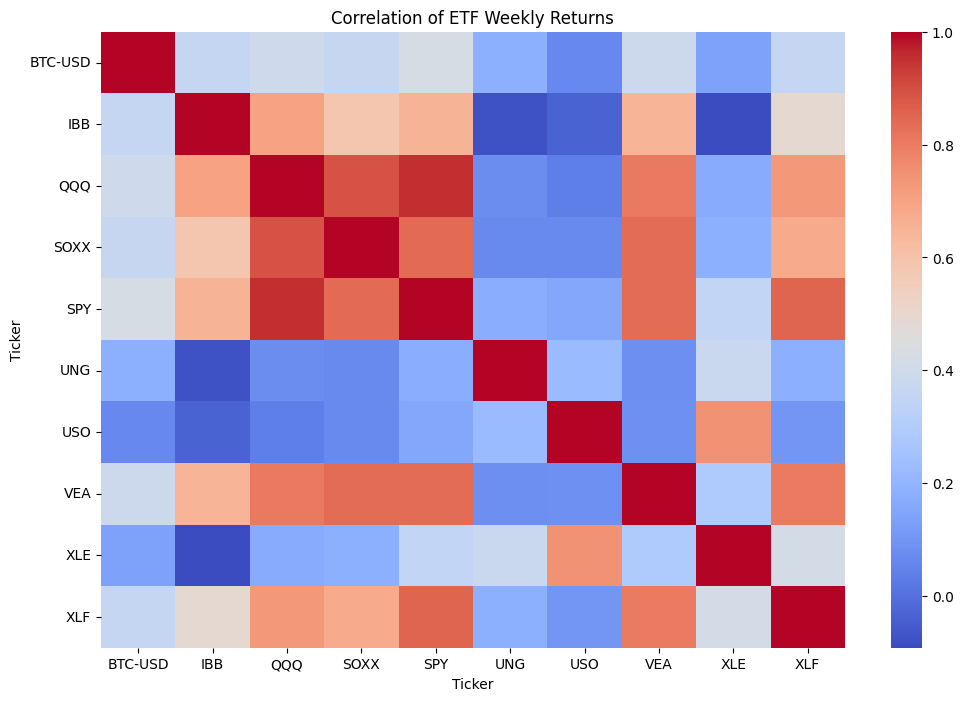

In [8]:
corr, cov = returns.corr(), returns.cov()
plot_heatmap(corr).set_title("Correlation of ETF Weekly Returns")

Text(0.5, 1.0, 'Correlation Distance of ETF Weekly Returns')

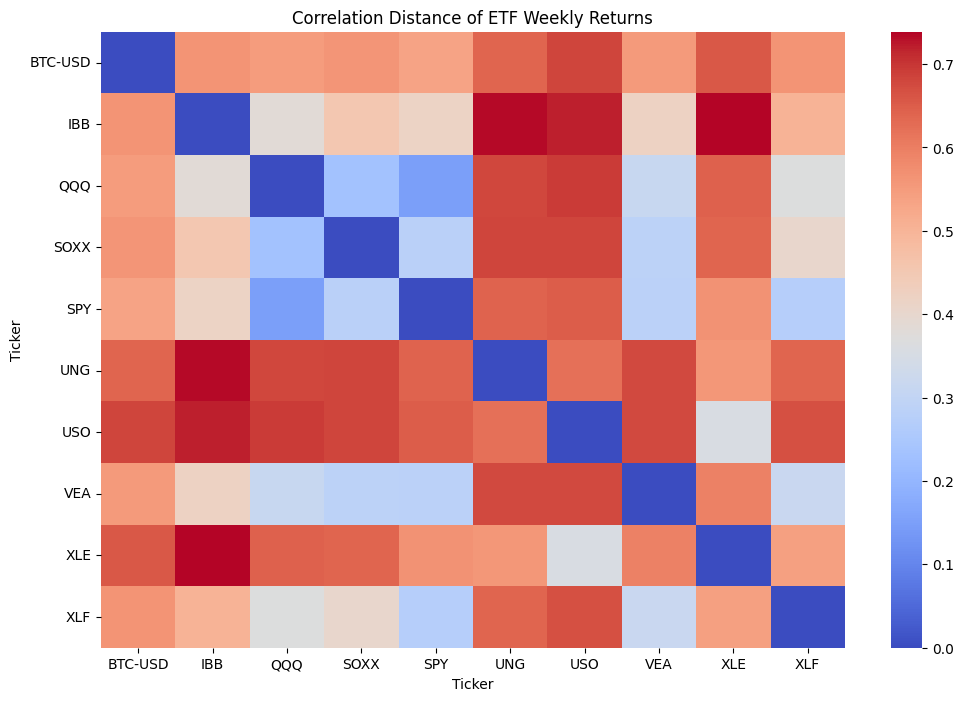

In [9]:
corr_distance = correlation_distance(corr)
plot_heatmap(corr_distance).set_title("Correlation Distance of ETF Weekly Returns")

Text(0, 0.5, 'Distance')

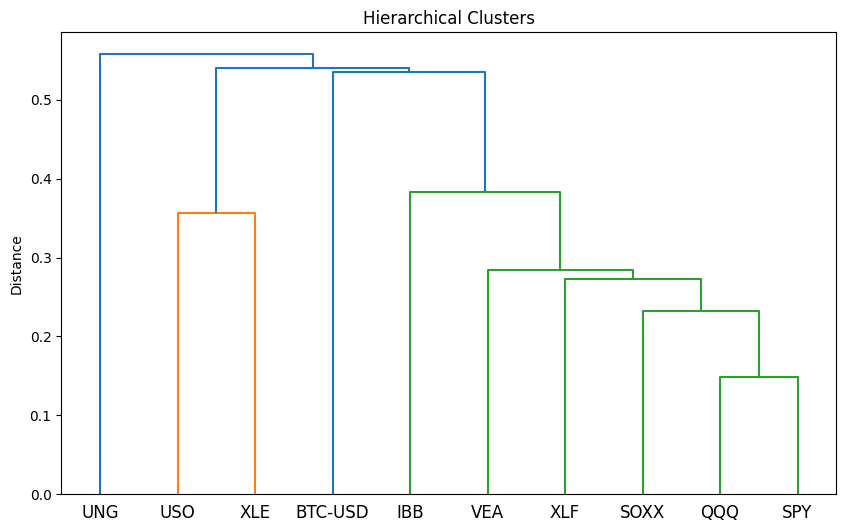

In [15]:
link = sch.linkage(squareform(corr_distance), method="single")
leaf_order = sch.leaves_list(link)


labels = corr_distance.index.to_list()

fig, ax = plt.subplots(figsize=(10, 6))
sch.dendrogram(link, labels=labels, ax=ax);
ax.set_title("Hierarchical Clusters")
ax.set_ylabel("Distance")

<Axes: xlabel='Ticker', ylabel='Ticker'>

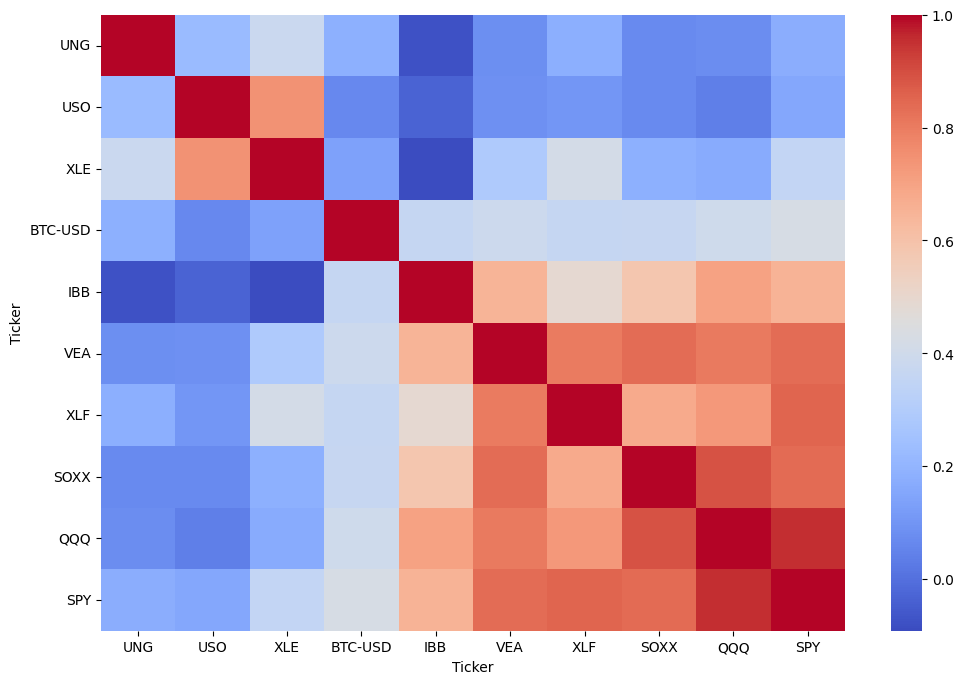

In [16]:
leaf_order_labels = corr.index[leaf_order]
new_corr = corr.loc[leaf_order_labels, leaf_order_labels]
plot_heatmap(new_corr)

We have thus formed a quasidiagonal matrix of our original ticker correlation matrix

16.2 Using the clustered covariance matrix V from exercise 1:

(a) Compute the HRP allocations.

(b) Compute the CLA allocations.

(c) Compute the IVP allocations

In [20]:
HRP_allocations = recursive_bisection(cov, leaf_order_labels)
IVP_allocations = pd.Series(getIVP(cov), index=cov.index)

mean = returns.mean(axis=0).to_numpy().reshape(-1, 1)

lb = np.zeros(mean.shape)
ub = np.ones(mean.shape)
cla = CLA.CLA(mean, cov.to_numpy(), lb, ub)
cla.solve()

CLA_allocations = pd.Series(index=cov.index, data=cla.w[-1].flatten())

summary = pd.concat([HRP_allocations, IVP_allocations, CLA_allocations], axis=1)
summary.columns = ["HRP", "IVP", "CLA"]
summary = summary.reindex(tickers)
summary

,HRP,IVP,CLA
Ticker,,,
XLF,0.134911,0.165508,0.186916
XLE,0.143901,0.068469,0.000000
BTC-USD,0.060299,0.037370,0.000000
VEA,0.155485,0.190748,0.348607
SOXX,0.051943,0.056319,0.000000
IBB,0.187737,0.116350,0.191416
SPY,0.090915,0.189011,0.072144
QQQ,0.051163,0.106368,0.000000
USO,0.092959,0.052520,0.170975


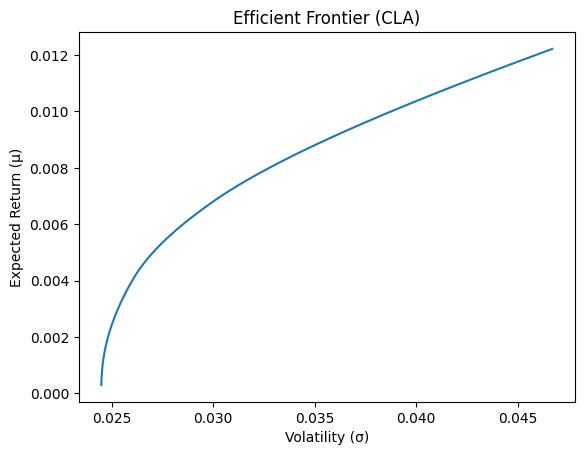

In [21]:
# Plot efficient frontier as sanity check
mu, sigma, weights = cla.efFrontier(points=1000*len(cla.w))

plt.plot(sigma, mu)
plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier (CLA)")

plt.show()

### 16.3

Using the covariance matrix V from exercise 1:
(a) Perform a spectral decomposition: VW = WΛ.

(b) Form an array 𝜀 by drawing N random numbers from a U[0, 1] distribution.

(c) Form an NxN matrix Λ̃ , where Λ̃ n,n = N𝜀nΛn,n(
∑N
n=1 𝜀n)
−1, n = 1,…,N.

(d) Compute Ṽ = WΛ̃ W−1.

(e) Repeat exercise 2, this time using Ṽ as covariance matrix. What allocation
method has been most impacted by the re-scaling of spectral variances?

<Axes: >

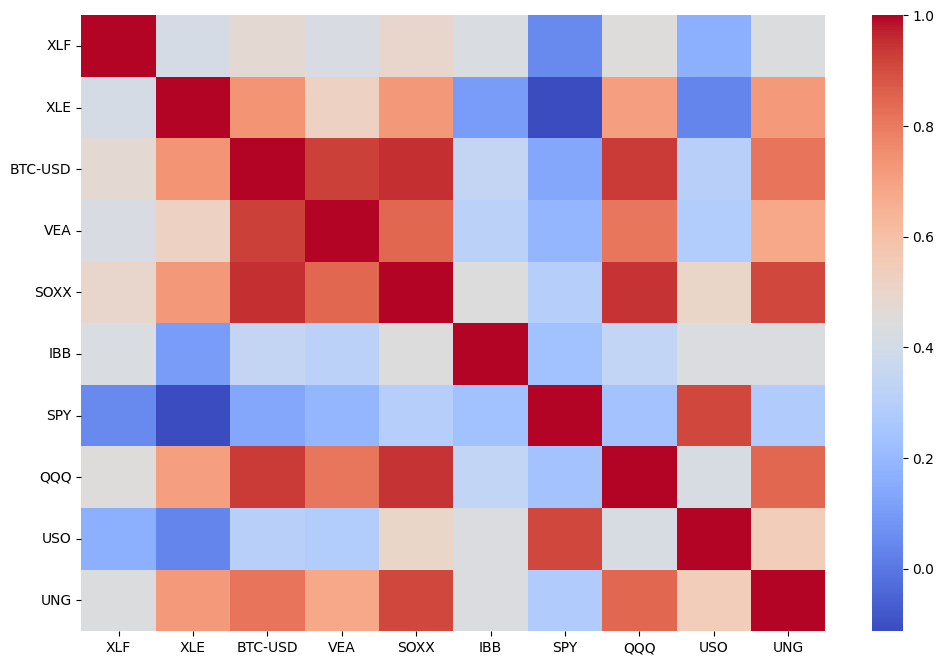

In [22]:
N = cov.shape[0]

#(a)
eigenvalues, eigenvectors = np.linalg.eig(cov)

#(b)
rng = np.random.default_rng(seed=12347)
epsilon = rng.uniform(low=0.0, high=1.0, size=N)

#(c)
lambda_tilde = np.diag((N * epsilon / epsilon.sum()) * eigenvalues)

#(d)
W = eigenvectors
v_tilde = W @ lambda_tilde @ np.linalg.inv(W)


Dinv = np.diag(1 / np.sqrt(np.diag(v_tilde))) 
corr_tilde = Dinv @ v_tilde @ Dinv

v_tilde = pd.DataFrame(index=tickers, columns=tickers, data = v_tilde)
corr_tilde = pd.DataFrame(index=tickers, columns=tickers, data = corr_tilde)

plot_heatmap(corr_tilde)

In [24]:
# Compute new allocations once noise has been added
HRP_allocations = recursive_bisection(v_tilde, leaf_order_labels)
IVP_allocations = pd.Series(getIVP(v_tilde), index=cov.index)

mean = returns.mean(axis=0).to_numpy().reshape(-1, 1) # doesn't matter for MVP

lb = np.zeros(mean.shape)
ub = np.ones(mean.shape)
cla = CLA.CLA(mean, v_tilde.to_numpy(), lb, ub)
cla.solve()

CLA_allocations = pd.Series(index=cov.index, data=cla.w[-1].flatten())

noise_summary = pd.concat([HRP_allocations, IVP_allocations, CLA_allocations], axis=1)
noise_summary.columns = ["HRP", "IVP", "CLA"]
noise_summary = noise_summary.reindex(tickers)
noise_summary

,HRP,IVP,CLA
Ticker,,,
XLF,0.046858,0.167751,0.000000
XLE,0.147168,0.045621,0.000000
BTC-USD,0.097145,0.035601,0.000000
VEA,0.074272,0.204067,0.531733
SOXX,0.177381,0.056429,0.000000
IBB,0.009364,0.147081,0.351121
SPY,0.028602,0.181904,0.000000
QQQ,0.170859,0.116185,0.000000
USO,0.053100,0.034161,0.117146


In [25]:
# use cosine similarty as metric for how much allocations have changed

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

print("HRP similarity:", cosine_similarity(summary["HRP"], noise_summary["HRP"]))
print("IVP similarity:", cosine_similarity(summary["IVP"], noise_summary["IVP"]))
print("CLA similarity:", cosine_similarity(summary["CLA"], noise_summary["CLA"]))


HRP similarity: 0.5876807695822649
IVP similarity: 0.9928280364906052
CLA similarity: 0.8803485681347649


We can see that the CLA portfolio is actually less affected by the noise than the HRP portfolio. This actually makes sense; HRP is more robust to idiosyncratic noise. However, because we've added noise by shocking the PCA factors, it is actually market systematic noise.